# Anime Recommendation

## Background

In this project, we want to build a better anime recommendation system based only on user viewing history. We will use user-based collaborative filtering to do the task.

In user-based collaborative filtering:
- users are deemed similar if they like similar items
- we first discover which users are similar
- then recommend items that other similar users like

For example
* Sunny likes paintings by Monet, Picasso and Dali.
* Ted likes paintings by Monet and Picasso.

Sunny and Ted are similar because they like some of the same artists. Sunny likes Dali but Ted has never seen a Dali painting.
So let's recommend Dali to Ted.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?resource=download&select=anime.csv) data from Kaggle platform.

In [1]:
# Package imports
from zipfile import ZipFile

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Extract data  
# specifying the zip file name
file_name = "/content/drive/MyDrive/anime.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip_:
    # printing all the contents of the zip file
    zip_.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip_.extractall()
    print('Done!')

File Name                                             Modified             Size
anime.csv                                      2019-09-20 04:05:10       936463
rating.csv                                     2019-09-20 04:05:12    111404899
Extracting all the files now...
Done!


In [9]:
# Load anime.csv
animes = pd.read_csv('anime.csv')

animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Some simple descriptive statistic.

In [10]:
# Descriptive statistic
animes[["rating", "members"]].describe()

,rating,members
count,12064.000000,1.229400e+04
mean,6.473902,1.807134e+04
std,1.026746,5.482068e+04
min,1.670000,5.000000e+00
25%,5.880000,2.250000e+02
50%,6.570000,1.550000e+03
75%,7.180000,9.437000e+03
max,10.000000,1.013917e+06


In [11]:
# Grouped descriptive statistics
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
animes \
    .groupby('type')["rating"] \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

type,Movie,Music,ONA,OVA,Special,TV
mean,6.318058,5.588996,5.643298,6.375221,6.523501,6.902299
std,1.211988,0.958440,1.127091,0.858358,0.887762,0.863526
min,1.920000,3.280000,2.580000,2.000000,1.670000,2.670000
q25,5.420000,5.010000,4.870000,5.850000,6.085000,6.440000
median,6.470000,5.625000,5.755000,6.380000,6.630000,6.940000
q75,7.250000,6.152500,6.412500,6.920000,7.110000,7.460000
max,10.000000,8.380000,8.260000,9.250000,8.660000,9.600000


Information about dataset from the docs.

* `anime_id` - myanimelist.net's unique id identifying an anime.
* `name` - full name of anime.
* `genre` - comma separated list of genres for this anime.
* `type` - movie, TV, OVA, etc.
* `episodes` - how many episodes in this show. (1 if movie).
* `rating` - average rating out of 10 for this anime.
* `members` - number of community members that are in this anime's "group".

In [12]:
# Load rating.csv
ratings = pd.read_csv('rating.csv')

ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Information about dataset from the docs.

* `user_id` - non identifiable randomly generated user id.
* `anime_id` - the anime that this user has rated.
* `rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

From the documentation above, we knew that rating = -1 means that the user watched the anime but didn't assign a rating. We could remove those data since it doesn't added any additional information.

In [13]:
ratings = ratings[ratings["rating"] != -1]

ratings.groupby(["rating"])["rating"].count()

rating
1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: rating, dtype: int64

There are 6337241 rating posted.
From total 69600 unique user id.
And rate total 12294 different animes.


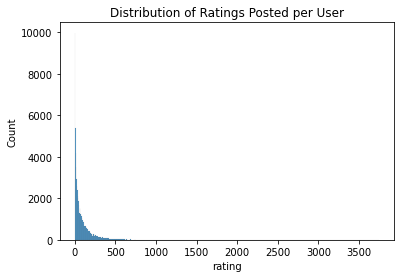

In [16]:
# number of ratings
print("There are", str(len(ratings)), "rating posted.")

# number of users
print("From total", str(len(ratings['user_id'].unique())), "unique user id.")

# number of unique animes (in anime list, not ratings)
print("And rate total", str(len(animes['anime_id'].unique())), "different animes.")

# avg number of anime rated per user
ratings_per_user = ratings.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

# distribution of ratings posted per user
_ = plt.title('Distribution of Ratings Posted per User')
_ = sns.histplot(ratings_per_user)
plt.show()

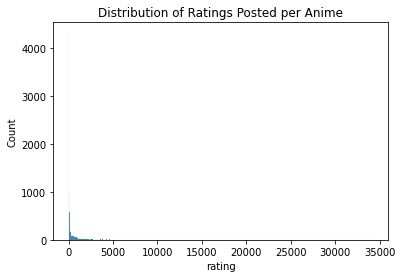

In [15]:
# avg number of ratings given per anime
ratings_per_anime = ratings.groupby('anime_id')['rating'].count()
statistics.mean(ratings_per_anime.tolist())

# distribution of ratings per anime
_ = plt.title('Distribution of Ratings Posted per Anime')
_ = sns.histplot(ratings_per_anime)
plt.show()

## Build Recommender

In user-based collaborative filtering, vectors representing users are essentially lists of the ratings they’ve given. So the more anime in our universe, the more dimensionality per user.

Let's reduce the amount of data to crunch by removing anime that hasn’t been rated by many users. Make a list of anime to keep based on id.

In [17]:
# counts of ratings per anime as a df
ratings_per_anime_df = pd.DataFrame(ratings_per_anime)

# remove if < 1000 ratings
filtered_ratings_per_anime_df = ratings_per_anime_df[ratings_per_anime_df.rating >= 1000]

# build a list of anime_ids to keep
popular_anime = filtered_ratings_per_anime_df.index.tolist()

And users who haven’t rated many anime.

In [18]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)

# remove if < 500
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 500]

# build a list of user_ids to keep
prolific_users = filtered_ratings_per_user_df.index.tolist()

Now filter out anime and users not in those lists.

In [19]:
filtered_ratings = ratings[ratings.anime_id.isin(popular_anime)]
filtered_ratings = ratings[ratings.user_id.isin(prolific_users)]
len(filtered_ratings)

1005314

We’re down from 6M to 1M rating data points. Nice.

Let's build a rating matrix between users and animes.

In [20]:
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='anime_id', values='rating')

# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)

# display the top few rows
rating_matrix.head()

anime_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                   
226         8.0    0.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         7.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
392         7.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0    7.0   
446         9.0    8.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  19     20     22     23     24     25     26     27     28     \
user_id                                                                   
226         0.0    7.0    0.0    0.0    0.0    6.0    0.0    7.0    0.0   
271         0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0   10.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0   
392         0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
446        10.0    0.0    0.0    0.0    0.0    0.0    9.0    8.0    0.0   

anime_id  29     30     31     32     33     43     44     45     46     \
user_id                                                                   
226         0.0    0.0    0.0    0.0    0.0    0.0    0.0    8.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0    7.0    7.0    8.0    0.0    0.0    9.0    7.0    7.0   
392         0.0    0.0    0.0    0.0    7.0    0.0   10.0    7.0    8.0   
446         0.0    0.0    0.0    0.0    9.0    9.0    0.0    0.0    0.0   

anime_id  47     48     49     50     51     52     53     54     55     \
user_id                                                                   
226         0.0    7.0    0.0    8.0    0.0    0.0    8.0    0.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0    0.0    8.0    8.0    0.0    0.0    0.0    0.0    0.0   
392         8.0    0.0    0.0    0.0    0.0    0.0    6.0    7.0    0.0   
446         0.0    8.0    0.0   10.0    0.0    0.0    0.0    0.0    0.0   

anime_id  56     57     58     59     60     61     62     63     64     \
user_id                                                                   
226         0.0    0.0    6.0    8.0    7.0    7.0    7.0    7.0    6.0   
271         0.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0    0.0   
294         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
392         0.0    7.0    0.0    0.0    7.0    0.0    0.0    0.0    0.0   
446         6.0    0.0    0.0    0.0    9.0    8.0    0.0    0.0    0.0   

anime_id  65     66     67     68     69     71     72     73     74     \
user_id                                                                   
226         0.0    0.0    7.0    5.0    0.0    7.0    7.0    7.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0    0.0    0.0    9.0    0.0    8.0    7.0    7.0    0.0   
392         0.0    0.0    0.0    7.0    0.0    8.0    7.0    6.0    0.0   
446         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  75     76     77     79     80     81     82     83     84     \
user_id                                                                   
226         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
392         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
446         0.0    0.0    0.0    9.0    0.0    0.0    0.0    0.0    0.0   

anime_id  85     86     87     88     89     90     91     92     93     \
user_id                                                                   
226         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
271         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294         0.0   

Write a function to find the most similar users to the current_user using cosine similarity. We’ve arbitrarily decided to find the 3 most similar users.

And picked “226” as our current user, but we could have picked anyone.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users
    
current_user = 226

# try it out
similar_user_indices = similar_users(current_user, rating_matrix)
print(similar_user_indices)

[30773, 39021, 45603]


Now write a function to make the recommendation. We’ve set the function to return the 5 top recommended anime.

In [22]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n anime   
    top_n_anime = similar_users_df_ordered.head(items)
    top_n_anime_indices = top_n_anime.index.tolist()
    # lookup these anime in the other dataframe to find names
    anime_information = animes[animes['anime_id'].isin(top_n_anime_indices)]
    
    return anime_information #items

# try it out
recommend_item(226, similar_user_indices, rating_matrix)

,anime_id,name,genre,type,episodes,rating,members
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
39,12365,Bakuman. 3rd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.71,133620
87,10030,Bakuman. 2nd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.53,151561
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817
184,7674,Bakuman.,"Comedy, Romance, Shounen",TV,25,8.35,246899


There we have it! The 5 highest-rated anime from the most similar users that our current user has not yet watched.

# Question

1. Bagaimana jika recommendation system hanya dikhusukan untuk rekomendasi film (type='Movie')? Buat rekomendasi 5 film rekomendasi untuk user_id 226 berdasarkan 5 user paling mirip dengan user_id 226.

In [23]:
# Load anime.csv
animes = pd.read_csv('anime.csv')
animes = animes[animes['type'] == 'Movie']
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1,9.05,102733
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
18,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",Movie,1,8.84,226193


In [24]:
animes[["rating", "members"]].describe()

,rating,members
count,2297.000000,2348.000000
mean,6.318058,10360.340716
std,1.211988,30886.364136
min,1.920000,5.000000
25%,5.420000,120.000000
50%,6.470000,499.500000
75%,7.250000,4189.250000
max,10.000000,466254.000000


In [25]:
# Load rating.csv
ratings = pd.read_csv('rating.csv')

ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


From the documentation above, we knew that rating = -1 means that the user watched the anime but didn't assign a rating. We could remove those data since it doesn't added any additional information.

In [26]:
animes_merge = animes.merge(ratings, on = 'anime_id', how = 'inner')
animes_merge = animes_merge.rename(columns={"rating_x": "avg_rating", "rating_y": "rating"})

animes_merge.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


Merge anime with rating column since we want to focus to movie type only

In [27]:
ratings = animes_merge[animes_merge["rating"] != -1]

ratings.groupby(["rating"])["rating"].count()

rating
1       1545
2       2472
3       4558
4      12439
5      33718
6      76831
7     173949
8     218467
9     174873
10    143301
Name: rating, dtype: int64

There are 842153 rating posted.
From total 50715 unique user id.
And rate total 2348 different animes.


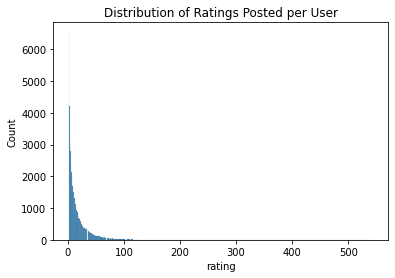

In [28]:
# number of ratings
print("There are", str(len(ratings)), "rating posted.")

# number of users
print("From total", str(len(ratings['user_id'].unique())), "unique user id.")

# number of unique animes (in anime list, not ratings)
print("And rate total", str(len(animes['anime_id'].unique())), "different animes.")

# avg number of anime rated per user
ratings_per_user = ratings.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

# distribution of ratings posted per user
_ = plt.title('Distribution of Ratings Posted per User')
_ = sns.histplot(ratings_per_user)
plt.show()

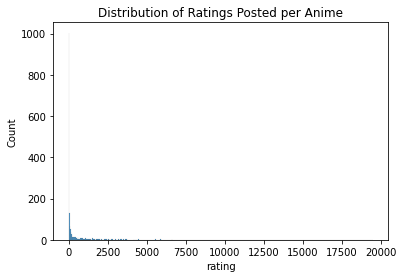

In [29]:
# avg number of ratings given per anime
ratings_per_anime = ratings.groupby('anime_id')['rating'].count()
statistics.mean(ratings_per_anime.tolist())

# distribution of ratings per anime
_ = plt.title('Distribution of Ratings Posted per Anime')
_ = sns.histplot(ratings_per_anime)
plt.show()

in this case, we are not set filter for the popular anime movies since our target is user_id 226 because, there are just only a few movies that he/she has watched

In [30]:
rating_matrix = animes_merge.pivot_table(index='user_id', columns='anime_id', values='rating')

# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)

# display the top few rows
rating_matrix.head()

anime_id  5      31     32     43     46     47     54     83     87     \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    8.0    0.0    0.0    0.0   
6           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  88     155    164    187    199    212    216    219    304    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0   10.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0   
6           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  313    315    317    371    372    378    393    405    415    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0   
6           0.0    0.0   -1.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  416    418    420    430    431    433    437    441    442    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   -1.0   
3           0.0    0.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
6           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  449    450    451    452    459    460    461    462    463    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  464    465    468    475    484    492    493    496    502    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  504    512    513    515    520    522    523    528    531    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0    0.0   
6           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  536    543    544    548    565    570    572    578    585    \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0   

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(user_id, matrix, k=5): #k = jumlah orang yang dijadikan acuan
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users
    
current_user = 226

# try it out
similar_user_indices = similar_users(current_user, rating_matrix)
print(similar_user_indices)

[65713, 45456, 64233, 43384, 72907]


In [32]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n anime   
    top_n_anime = similar_users_df_ordered.head(items)
    top_n_anime_indices = top_n_anime.index.tolist()
    # lookup these anime in the other dataframe to find names
    anime_information = animes[animes['anime_id'].isin(top_n_anime_indices)]
    
    return anime_information #items

# try it out
recommend_item(226, similar_user_indices, rating_matrix)

,anime_id,name,genre,type,episodes,rating,members
784,13667,Naruto: Shippuuden Movie 6 - Road to Ninja,"Action, Adventure, Martial Arts, Shounen, Supe...",Movie,1,7.84,87369
1226,901,"Dragon Ball Z Movie 08: Moetsukiro!! Nessen, R...","Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,7.62,65953
1237,10589,Naruto: Shippuuden Movie 5 - Blood Prison,"Action, Adventure, Martial Arts, Mystery, Shou...",Movie,1,7.62,75660
1472,8246,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P...",Movie,1,7.53,84527
2514,898,Dragon Ball Z Movie 05: Tobikkiri no Saikyou t...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,7.24,59207
